In [68]:
# from  lunarLanding import DQNAgent

%matplotlib inline

from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Dropout, Activation, Input, concatenate, add, Conv1D, MaxPooling1D
from keras.layers import Flatten
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

import pylab as pl
from IPython import display


import itertools
import gym

import numpy as np
from scipy.special import softmax
import random
from sklearn import preprocessing
import matplotlib.pyplot as plt
import time

import os

['/job:localhost/replica:0/task:0/device:GPU:0']


In [129]:
import random
import gym
import numpy as np
from collections import deque
from scipy.special import softmax
import random
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.models import Sequential
import time

import os

# Deep Q-learning Agent
class DQNAgent:
    def __init__(self, state_size, action_size, memsize = 25000, ga = 0.95, explore_rate = 1, explore_decay = 0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen = memsize)
        self.gamma = ga    # discount rate
        self.epsilon = explore_rate  # exploration rate
        self.epsilon_min = 0.2
        self.epsilon_decay = explore_decay
        self.target_model = Sequential()
        self.engine_model = Sequential()

    def remember(self, state, action, reward, next_state, done):
        if not done:
            self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):

        if np.random.rand() <= self.epsilon:
            chose = np.random.randint(0,4)
            return chose
        
        ACTION_SIZE = 4
        STATE_SIZE = 8
        bestStep = 0
        initialStep = np_utils.to_categorical(0, ACTION_SIZE).reshape(1, ACTION_SIZE)
        best_reward = self.target_model.predict([state.reshape(1, STATE_SIZE,1), initialStep])[0]
        for action in range(1, ACTION_SIZE):
            step = np_utils.to_categorical(action, ACTION_SIZE).reshape(1, ACTION_SIZE)
            predict = self.target_model.predict([state.reshape(1, STATE_SIZE,1), step])
            if(predict[0] > best_reward):
                bestStep = action
                best_reward = predict
                
        return bestStep
#     def replay(self, batch_size):
#         minibatch = random.sample(self.memory, batch_size)
#         xs = []
#         ys = []

#         for state, action, reward, next_state, done in minibatch:
#             target = reward

#             if not done:
#                 target = reward + np.multiply (self.gamma , self.model.predict(next_state)[0] )
#             else:
#                 target = np.multiply (self.gamma , self.model.predict(next_state)[0] )
                
#             xs.append(state[0])
#             ys.append(target)
#         xs = np.array(xs)
#         ys = np.array(ys)
#         self.model.fit(xs, ys, epochs= 1, verbose=0 , batch_size=batch_size)
                
#         if self.epsilon > self.epsilon_min:
#             self.epsilon *= self.epsilon_decay
    
    def save_model(self, model_name = './checkpoint.h5', mem_name = 'memory'):
        self.target_model.save(model_name)

    def load_model(self,  model_name = './checkpoint.h5' , mem_name = 'memory.npy'):
        self.target_model.load_weights(model_name)
        self.engine_model.load_weights(model_name)
        self.memory = np.load(mem_name, allow_pickle=True)
        self.memory = deque(self.memory)
    def learn (self, roun):
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay ** 50
        output = list(itertools.islice(agent.memory, 0, None))
        xs_state = []
        xs_action = []
        ys = []
        for i in output:
            ys.append(i[2])
#             print('reward',i[2])
            step = np_utils.to_categorical(i[1], 4).reshape(1, 4)

            xs_state.append(i[0][0])
            xs_action.append(step)

        ys = np.array(ys)
        lgn = len(xs_state)
        xs_action = np.array(xs_action).reshape(lgn, 4)
        xs_state = np.expand_dims(xs_state, axis = 2)
#         print(xs.shape)
        es = EarlyStopping()
        self.engine_model.fit([xs_state, xs_action], ys, epochs = 2, verbose = 1, batch_size= 64, validation_split = 0.1)
        del self.memory
        
        self.memory = deque(maxlen = 10000)
#         print(len(self.memory))
        self.engine_model.save_weights("checkpoint-cnn.h5")
        self.target_model.set_weights(self.engine_model.get_weights()) 

In [147]:
input_state = Input(shape=(8,1))
input_action = Input(shape=(4,))

m = Conv1D(filters=4, kernel_size=2,padding='same', activation='selu')(input_state)
m = BatchNormalization()(m)
m = Conv1D(filters=8, kernel_size=2, padding='same', activation='selu')(m)
m = BatchNormalization()(m)
m = Conv1D(filters=16, kernel_size=2, padding='same', activation='selu')(m)
m = BatchNormalization()(m)

m = Flatten()(m)


# m = Model(inputs = input_state, outputs = m)

#####

m_i = Dense(8,activation='relu')(input_action)
m_i = BatchNormalization()(m_i)

m_i = Dense(8,activation='relu')(m_i)
m_i = BatchNormalization()(m_i)

# m_i = Model(inputs = input_action, outputs = m_i)

u = concatenate([m,m_i])

u = Dense(128, activation='relu')(u)
u = BatchNormalization()(u)

u = Dense(64, activation='relu')(u)
u = BatchNormalization()(u)

u = Dense(16, activation='relu')(u)
u = BatchNormalization()(u)

u = Dense(1)(u)

u = Model(inputs= [input_state,input_action ], outputs = u)

u.compile(loss='mse', optimizer=Adam())
u.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_75 (InputLayer)           (None, 8, 1)         0                                            
__________________________________________________________________________________________________
conv1d_155 (Conv1D)             (None, 8, 4)         12          input_75[0][0]                   
__________________________________________________________________________________________________
batch_normalization_247 (BatchN (None, 8, 4)         16          conv1d_155[0][0]                 
__________________________________________________________________________________________________
conv1d_156 (Conv1D)             (None, 8, 8)         72          batch_normalization_247[0][0]    
__________________________________________________________________________________________________
input_76 (

In [148]:
env = gym.make('LunarLander-v2')
state_size = 8
action_size = 4
agent = DQNAgent(state_size, action_size, memsize= 10000)


agent.target_model = u
agent.engine_model = u
game_history = [0]

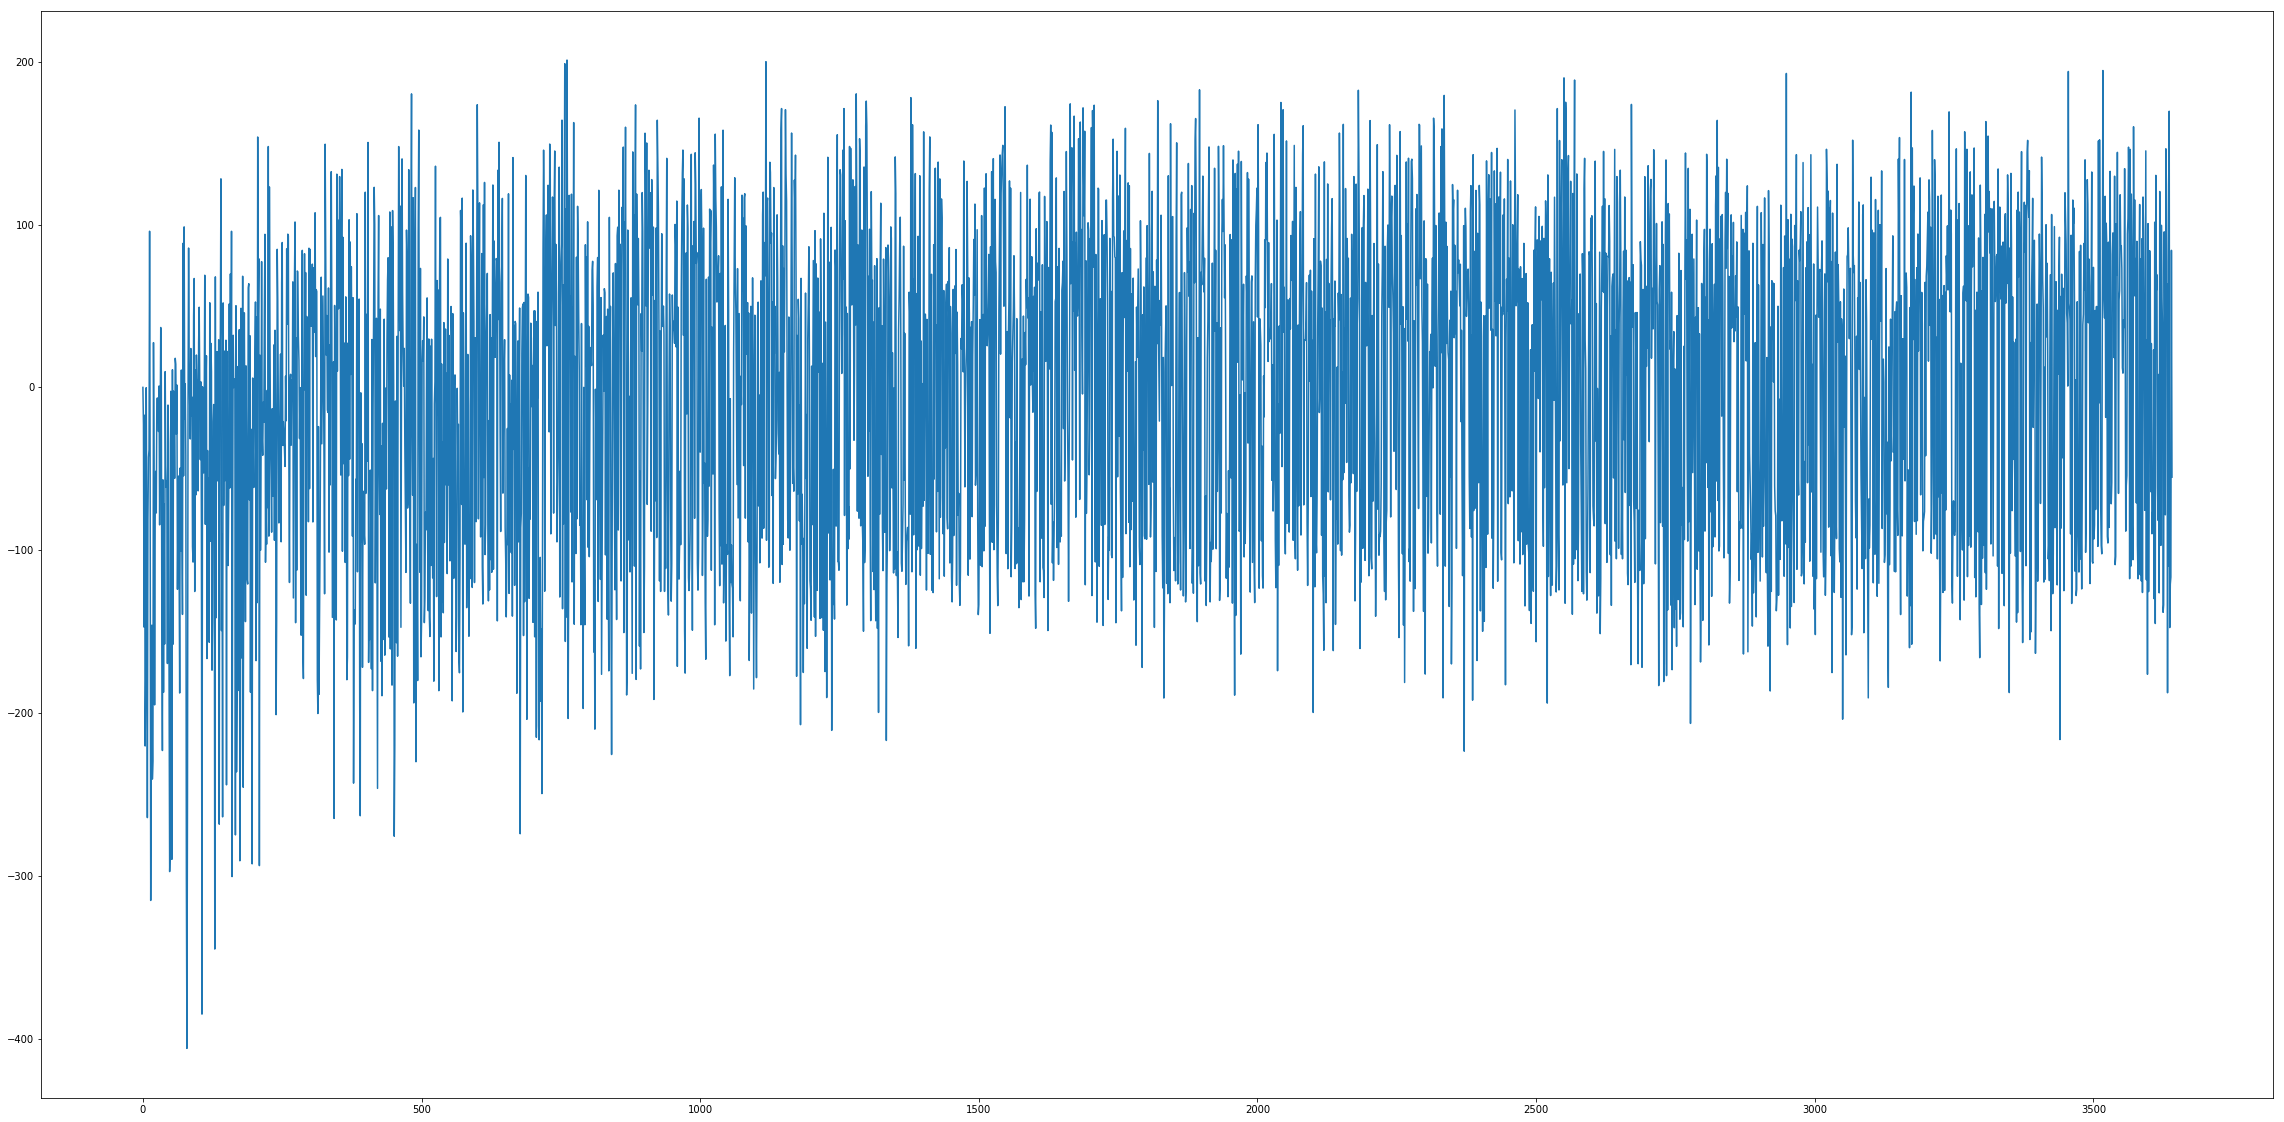

epi:3641 score: 61.78011582986366 mean:9.981084143464956 spent:5.699324607849121
epi:3642 score: 115.9441895477922 mean:9.696465100987856 spent:9.469753980636597
epi:3643 score: -67.58211273088553 mean:8.44527086464926 spent:3.7241156101226807
epi:3644 score: 119.6712476923917 mean:10.293288250747471 spent:9.217376947402954
epi:3645 score: 42.71024066853475 mean:10.184607563482663 spent:4.152254819869995
epi:3646 score: 83.85940149917518 mean:10.428785438353595 spent:4.199095964431763
epi:3647 score: 125.88841811299696 mean:10.504343911980161 spent:6.895120859146118
epi:3648 score: 88.93547292926839 mean:10.529603510711354 spent:9.523874282836914
epi:3649 score: -133.7843404378457 mean:8.320909352327593 spent:5.809715747833252
epi:3650 score: -113.46448091046948 mean:6.456292806910657 spent:4.940759658813477
epi:3651 score: 107.41384778391762 mean:7.4108807656608375 spent:4.607389211654663
epi:3652 score: 70.36527091998242 mean:8.027005268113244 spent:4.354274272918701
epi:3653 score: 

In [ ]:
done = False
batch_size = 30
explore
explore = True
prev_epi = 0
t_steps = 0
for episode in range(5000):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    start = time.time()
    for timee in range(450):

        action = agent.act(state)
        
        next_state, reward, done, _ = env.step(action)
        

        next_state = np.reshape(next_state, [1, state_size])

        agent.remember(state, action, reward, next_state, done)
        state = next_state
        
        if done:
            break
        
        total_reward += reward


    game_history.append(total_reward)
    print("epi:{} score: {} mean:{} spent:{}".format(episode, total_reward, np.mean(game_history[-100:]), time.time() - start))

    if episode - prev_epi >= 65:
        explore = False
        agent.learn(episode - prev_epi)
        prev_epi = episode
        agent.save_model()
        np.save("game_history", game_history)
        pl.figure(figsize=(40,20))
        pl.plot(game_history)
        display.clear_output(wait=True)
        display.display(pl.gcf())
